# Asphaltene energetics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Functions

In [2]:
def read_file(file_in):
  """
  Read file

  Parameters
  ----------
  file_in : string
    File (path and name) to be read

  Returns
  -------
  temp_data : list
    List of lists with the words in every line of the file read

  """

  temp_data = []

  f = open(file_in)

  for line in f:
    temp_data.append(line.split())

  f.close()

  return temp_data

In [3]:
def read_log_file(file_in):
  """Read log file from LAMMPS to extract thermo output"""

  temp_data = []

  f = open(file_in)

  for line in f:
    temp_data += [line]

  f.close()

  # Find thermo output

  i = 0
  start = []
  for line in temp_data:
    if 'Per MPI rank memory allocation (min/avg/max)' in line:
      start.append(i+1)
    i += 1

  # Determine thermo properties in log file

  labels = []
  for i in start:
    labels.append(temp_data[i].split())

  # Determine number of rows in thermo data

  i = 0
  end = []
  for line in temp_data:
    if 'Loop time of' in line:
      end.append(i)
    i += 1

  # Extract thermo data

  allData = []
  for i in range(len(start)):
    data = []
    for line in temp_data[start[i]+1 : end[i]]:
      data.append(list(map(float, line.split())))
    data = np.array(data)
    allData.append(data)

  del(temp_data)

  return (labels, allData)

In [4]:
def estimate_coef(x, y):
    # number of observations/points
    n = np.size(x)

    # mean of x and y vector
    m_x = np.mean(x)
    m_y = np.mean(y)

    # calculating cross-deviation and deviation about x
    SS_xy = np.sum(y*x) - n*m_y*m_x
    SS_xx = np.sum(x*x) - n*m_x*m_x

    # calculating regression coefficients
    b_1 = SS_xy / SS_xx
    b_0 = m_y - b_1*m_x

    return (b_0, b_1)

## Definitions

Colors from Mathematica:

In [5]:
colors = [(0.368417,0.506779,0.709798),\
          (0.880722,0.611041,0.142051),\
          (0.560181,0.691569,0.194885),\
          (0.922526,0.385626,0.209179),\
          (0.528488,0.470624,0.701351),\
          (0.772079,0.431554,0.102387),\
          (0.363898,0.618501,0.782349),\
          (1.,0.75,0.),\
          (0.647624,0.37816,0.614037),\
          (0.571589,0.586483,0.),\
          (0.915,0.3325,0.2125),\
          (0.400822,0.522007,0.85),\
          (0.972829,0.621644,0.073362),\
          (0.736783,0.358,0.503027),\
          (0.280264,0.715,0.429209)]

Font size:

In [6]:
ft = 19

LaTeX font:

In [7]:
# ft = 22
# plt.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif" : "Helvetica",
#     "mathtext.default": "regular"})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Charter"
# })

## Get data

In [7]:
path = '../data/'

In [9]:
# path = '/home/fperez/Documents/asphaltenes/model_3/toluene+methane-cases/400_K/'

In [9]:
pressure_org = [50, 75, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 300, 400, 700]

In [12]:
npress = len(pressure_org)

In [11]:
names_list = ['Press', 'E_vdwl', 'E_tail', 'c_pairA', 'c_pairS', 'c_bondA', 'c_angleA', 'c_peasph', 'PotEng', 'Lx', 'Density']

In [14]:
pressure = np.zeros(npress)

Initialize data storage:

In [13]:
vdw_vec     = []
tail_vec    = []
pairAA_vec  = []
pairSS_vec  = []
pairAS_vec  = []
pairAS2_vec = []
bondA_vec   = []
angleA_vec  = []
peA_vec     = []
volume_vec  = []
density_vec = []

In [15]:
for i in pressure_org:
  file = path + str(i) +'_atm/5-production_npt/log.lammps'
  labels, thermoData = read_log_file(file)
  time = thermoData[-1][:,1]/10**6
  
  n_index = {}
  for j in names_list:
    if i < 100 and j == 'Lx':
      j = 'Lz'
    n_index[j] = labels[-1].index(j)

  press   = thermoData[-1][:,n_index['Press']]
  vdw     = thermoData[-1][:,n_index['E_vdwl']]/1000
  tail    = thermoData[-1][:,n_index['E_tail']]/1000
  pair_A  = thermoData[-1][:,n_index['c_pairA']]/1000
  pair_S  = thermoData[-1][:,n_index['c_pairS']]/1000
  bondA   = thermoData[-1][:,n_index['c_bondA']]/1000
  angleA  = thermoData[-1][:,n_index['c_angleA']]/1000
  peasph  = thermoData[-1][:,n_index['c_peasph']]/1000
  density = thermoData[-1][:,n_index['Density']]
  
  pressure[pressure_org.index(i)] = np.mean(press)
  
  if i < 100:
    lx = thermoData[-1][:,n_index['Lz']]/10
  else:
    lx = thermoData[-1][:,n_index['Lx']]/10
  
  pairAA  = vdw - tail - pair_S
  pairSS  = vdw - tail - pair_A
  pairAS  = vdw - tail - pairAA - pairSS
  pairAS2 = peasph - pairAA - bondA - angleA 
  
  vdw_vec.append(vdw)
  tail_vec.append(tail)
  pairAA_vec.append(pairAA)
  pairAS_vec.append(pairAS)
  pairAS2_vec.append(pairAS2)
  pairSS_vec.append(pairSS)
  peA_vec.append(peasph)
  bondA_vec.append(bondA)
  angleA_vec.append(angleA)
  if i < 100:
    volume_vec.append(lx*12.5**2)
  else:
    volume_vec.append(lx**3)
  density_vec.append(density)

In [16]:
print(pressure)

[ 44.41018445  68.398995    99.9069284  110.10307107 120.1828183
 129.87888241 140.10612962 149.78299449 160.26432803 170.10666098
 180.08280018 189.93785039 200.09014433 209.97885471 219.92052345
 300.32679378 399.97537749 700.0386692 ]


## Plots

### van der Waals energy

In [17]:
vdw_mean = np.zeros(npress)
vdw_err = np.zeros(npress)

for i in range(npress):
  vdw_mean[i] = np.mean(vdw_vec[i])
  vdw_err[i] = 2*np.std(vdw_vec[i])/np.sqrt(len(vdw_vec[i]))

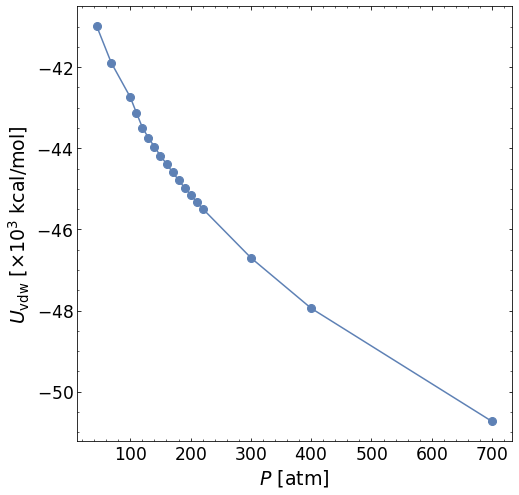

In [18]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, vdw_mean, yerr = vdw_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{vdw} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.show()

### Tail correction

The total van der Waals energy of the system is

$$U_{vdW} = U_{A-A} + U_{A-S} + U_{S-S} + U_{tail}.$$

In [19]:
tail_mean = np.zeros(npress)
tail_err = np.zeros(npress)

for i in range(npress):
  tail_mean[i] = np.mean(tail_vec[i])
  tail_err[i] = 2*np.std(tail_vec[i])/np.sqrt(len(tail_vec[i]))

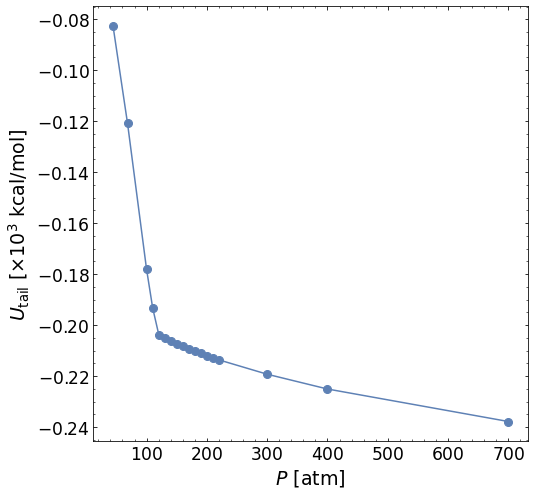

In [20]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, tail_mean, yerr = tail_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{tail} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.show()

### van der Waals energy - tail correction

In [22]:
vdwc_mean = np.zeros(npress)
vdwc_err = np.zeros(npress)

for i in range(npress):
  aux = vdw_vec[i] - tail_vec[i]
  vdwc_mean[i] = np.mean(aux)
  vdwc_err[i] = 2*np.std(aux)/np.sqrt(len(aux))

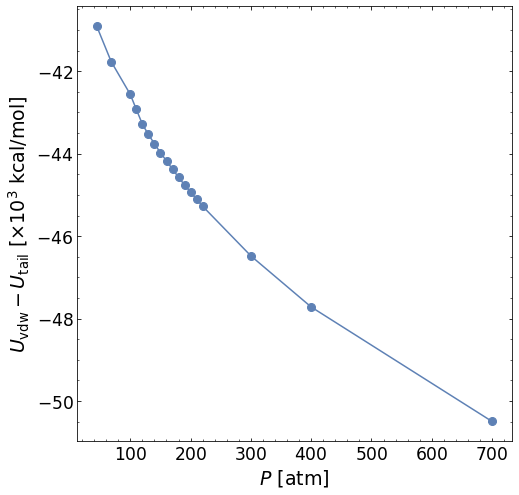

In [23]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, vdwc_mean, yerr = vdwc_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{vdw} - U_\mathrm{tail} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/vdw.png', dpi=150)
plt.show()

### Total potential energy of asphaltenes = A-A + A-S + intramolecular

The total potential energy of asphaltens comes from:
- Asphaltene-asphaltene interactions
- Asphaltene-solvent interactions
- Intramolecular energy
  - Bonds
  - Angles
  
Thus,

$$U_{asp} = U_{A-A} + U_{A-S} + U_{bonds} + U_{angles}.$$

It is possible to dump $U_{vdW}^{A} = U_{A-A} + U_{A-S}$ and  $U_{vdW}^{S} = U_{S-S} + U_{S-A}$ from simulations. Therefore, it is possible to calculate $U_{A-A}$ using

$$U_{A-A} = U_{vdW} - U_{tail} - U_{A-S} - U_{S-S} = U_{vdW} - U_{tail} - U_{vdW}^{S},$$

$U_{S-S}$ using

$$U_{S-S} = U_{vdW} - U_{tail} - U_{A-S} - U_{A-A} = U_{vdW} - U_{tail} - U_{vdW}^{A},$$

and $U_{A-S}$ using

$$U_{A-S} = U_{asp} - U_{A-A} - U_{bonds} - U_{angles}$$

or

$$U_{A-S} = U_{vdW} - U_{tail} - U_{A-A} - U_{S-S}$$

In [24]:
pe_mean = np.zeros(npress)
pe_err = np.zeros(npress)

for i in range(npress):
  pe_mean[i] = np.mean(peA_vec[i])
  pe_err[i] = 2*np.std(peA_vec[i])/np.sqrt(len(peA_vec[i]))

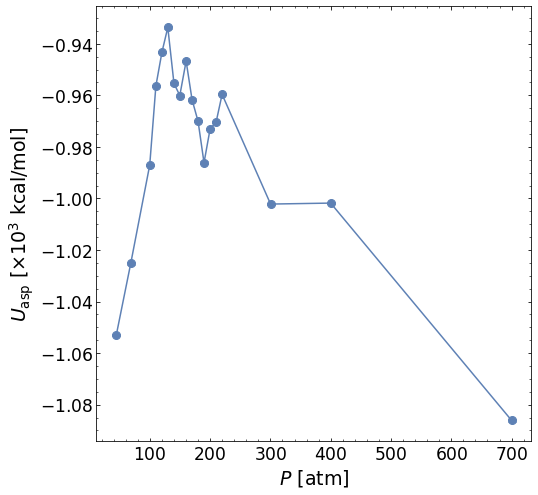

In [25]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, pe_mean, yerr = pe_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{asp} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('../plots/peasp.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Interaction A-A

In [26]:
aa_mean = np.zeros(npress)
aa_err = np.zeros(npress)

for i in range(npress):
  aa_mean[i] = np.mean(pairAA_vec[i])
  aa_err[i] = 2*np.std(pairAA_vec[i])/np.sqrt(len(pairAA_vec[i]))

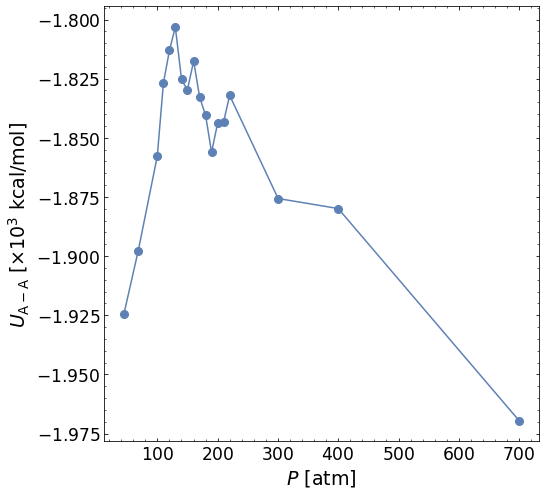

In [27]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, aa_mean, yerr = aa_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{A-A} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('../plots/asp_asp.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Interaction A-S

In [28]:
as_mean = np.zeros(npress)
as_err = np.zeros(npress)

for i in range(npress):
  as_mean[i] = np.mean(pairAS_vec[i])
  as_err[i] = 2*np.std(pairAS_vec[i])/np.sqrt(len(pairAS_vec[i]))

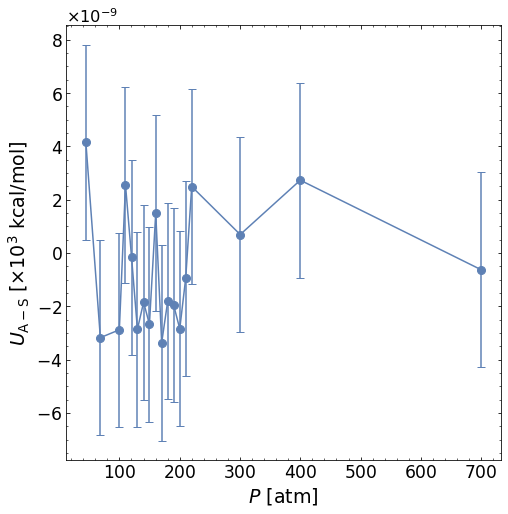

In [29]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, as_mean, yerr = as_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{A-S} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/asp_sol.png', dpi=150)
plt.show()

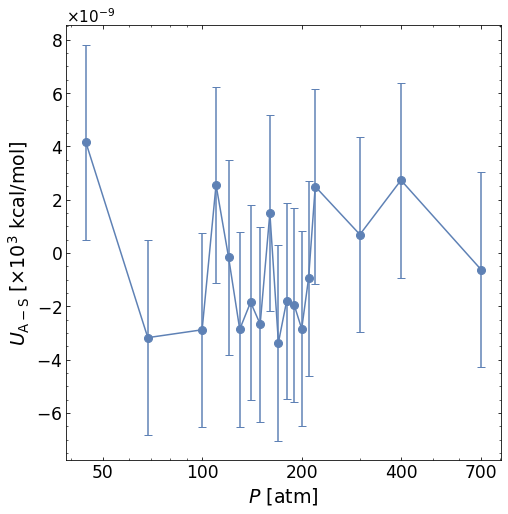

In [30]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, as_mean, yerr = as_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{A-S} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().set_xscale('log')
plt.gca().set_xticks([50,100,200,400,700])
plt.gca().set_xticklabels(['50','100','200','400','700'])
plt.gca().yaxis.offsetText.set_fontsize(0.8*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('../plots/asp_sol-lognormal.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [31]:
as2_mean = np.zeros(npress)
as2_err = np.zeros(npress)

for i in range(npress):
  as2_mean[i] = np.mean(pairAS2_vec[i])
  as2_err[i] = 2*np.std(pairAS2_vec[i])/np.sqrt(len(pairAS2_vec[i]))

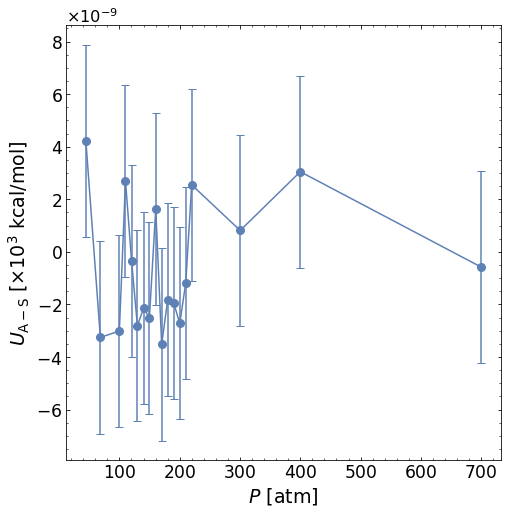

In [32]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, as2_mean, yerr = as2_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{A-S} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/asp_sol.png', dpi=150)
plt.show()

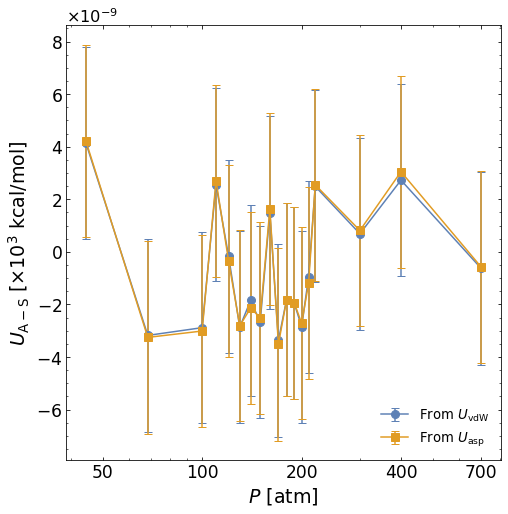

In [33]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, as_mean, yerr = as_err, capsize=4, fmt = '-o', markersize=8, label="From $U_\mathrm{vdW}$")
plt.errorbar(pressure, as2_mean, yerr = as2_err, capsize=4, fmt = '-s', markersize=8, label="From $U_\mathrm{asp}$")
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{A-S} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().set_xscale('log')
plt.gca().set_xticks([50,100,200,400,700])
plt.gca().set_xticklabels(['50','100','200','400','700'])
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.legend(loc='lower right', fontsize=0.7*ft, frameon=False)
# plt.savefig('../plots/asp_sol-comparison.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Bonds

In [34]:
bond_mean = np.zeros(npress)
bond_err = np.zeros(npress)

for i in range(npress):
  bond_mean[i] = np.mean(bondA_vec[i])
  bond_err[i] = np.std(2*bondA_vec[i])/np.sqrt(len(bondA_vec[i]))

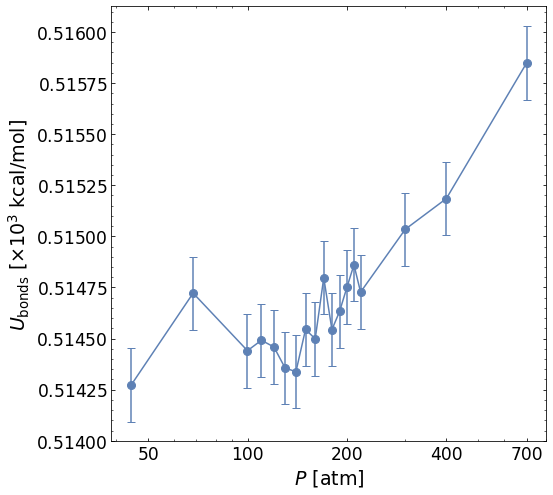

In [35]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, bond_mean, yerr = bond_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{bonds} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().set_xscale('log')
plt.gca().set_xticks([50,100,200,400,700])
plt.gca().set_xticklabels(['50','100','200','400','700'])
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('../plots/bonds.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Angles

In [36]:
angle_mean = np.zeros(npress)
angle_err = np.zeros(npress)

for i in range(npress):
  angle_mean[i] = np.mean(angleA_vec[i])
  angle_err[i] = np.std(2*angleA_vec[i])/np.sqrt(len(angleA_vec[i]))

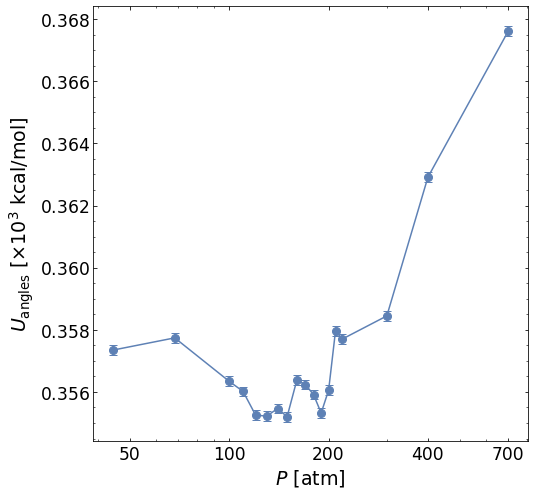

In [37]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, angle_mean, yerr = angle_err, capsize=4, fmt = '-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U_\mathrm{angles} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().set_xscale('log')
plt.gca().set_xticks([50,100,200,400,700])
plt.gca().set_xticklabels(['50','100','200','400','700'])
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('../plots/angles.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Potential energy: all together

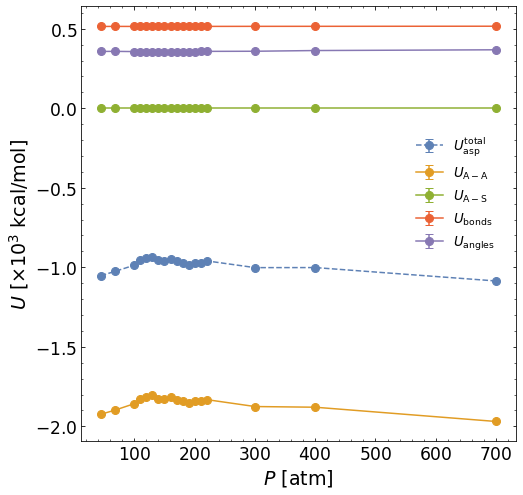

In [38]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, pe_mean, yerr = pe_err, capsize=4, fmt = '--o', markersize=8, label="$U_\mathrm{asp}^\mathrm{total}$")
plt.errorbar(pressure, aa_mean, yerr = aa_err, capsize=4, fmt = '-o', markersize=8, label="$U_\mathrm{A-A}$")
plt.errorbar(pressure, as_mean, yerr = as_err, capsize=4, fmt = '-o', markersize=8, label="$U_\mathrm{A-S}$")
plt.errorbar(pressure, bond_mean, yerr = bond_err, capsize=4, fmt = '-o', markersize=8, label="$U_\mathrm{bonds}$")
plt.errorbar(pressure, angle_mean, yerr = angle_err, capsize=4, fmt = '-o', markersize=8, label="$U_\mathrm{angles}$")
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$U \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.legend(loc='right', bbox_to_anchor=(0.98, 0.57), fontsize=0.7*ft, frameon=False)
# plt.savefig('../plots/pe-contributions.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

### Volume

In [39]:
vol_mean = np.zeros(npress)
vol_err = np.zeros(npress)

for i in range(npress):
  vol_mean[i] = np.mean(volume_vec[i])
  vol_err[i] = np.std(2*volume_vec[i])/np.sqrt(len(volume_vec[i]))

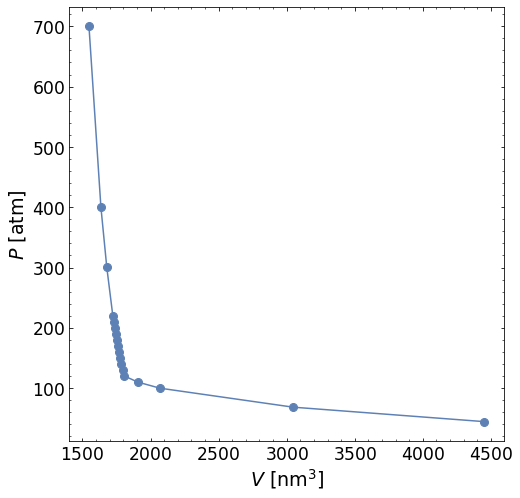

In [40]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(vol_mean, pressure, xerr=vol_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.xlabel(r'$V \ [\mathrm{nm}^3]$', fontsize=ft)
plt.ylabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/volume.png', dpi=150)
plt.show()

In [41]:
n_gas = 4 # Number of data values in gas phase (the first n_gas positions in pressure and volume)

b_gas = estimate_coef(vol_mean[:n_gas], pressure[:n_gas])
b_liquid = estimate_coef(vol_mean[n_gas:], pressure[n_gas:])

y_gas = b_gas[0] + b_gas[1]*vol_mean[:n_gas]
y_liquid = b_liquid[0] + b_liquid[1]*vol_mean[n_gas:]

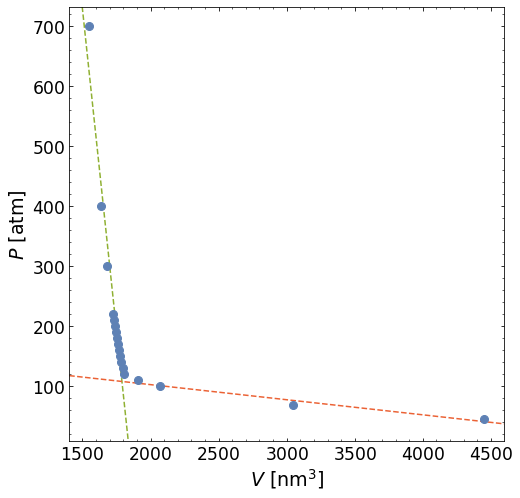

In [42]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(vol_mean, pressure, xerr=vol_err, capsize=4, fmt='o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.xlabel(r'$V \ [\mathrm{nm}^3]$', fontsize=ft)
plt.ylabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.axline((vol_mean[n_gas], y_liquid[0]), slope=b_liquid[1], color=colors[2], linestyle="--")
plt.axline((vol_mean[0], y_gas[0]), slope=b_gas[1], color=colors[3], linestyle="--")
# ax.plot(vol_mean[:n_gas], y_gas, color = colors[3], linestyle="--")
# ax.plot(vol_mean[n_gas:], y_liquid, color = colors[2], linestyle="--")
# plt.savefig('./plots/bubble_point_pressure.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [43]:
print('The linear fit for the gas phase is P = {:.3f} + {:.3f} V'.format(b_gas[0], b_gas[1]))
print('The linear fit for the liquid phase is P = {:.3f} + {:.3f} V'.format(b_liquid[0], b_liquid[1]))

The linear fit for the gas phase is P = 152.892 + -0.025 V
The linear fit for the liquid phase is P = 3940.228 + -2.141 V


In [44]:
V_b = -(b_liquid[0] - b_gas[0])/(b_liquid[1] - b_gas[1]) # nm**3
print('The volume at the bubble point pressure is {:.3f} nm**3'.format(V_b))

The volume at the bubble point pressure is 1789.951 nm**3


In [45]:
P_b = b_liquid[0] + b_liquid[1]*V_b
print('The bubble point pressure is {:.3f} atm'.format(P_b))

The bubble point pressure is 107.833 atm


### Density

In [46]:
rho_mean = np.zeros(npress)
rho_err = np.zeros(npress)

for i in range(npress):
  rho_mean[i] = np.mean(density_vec[i])
  rho_err[i] = np.std(2*density_vec[i])/np.sqrt(len(density_vec[i]))

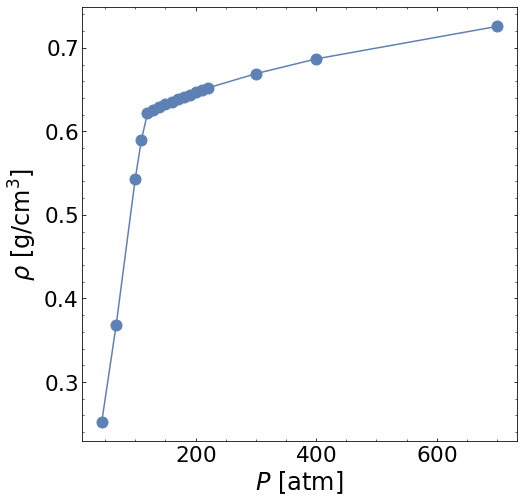

In [47]:
lft = 24
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, rho_mean, yerr=rho_err, capsize=4, fmt='-o', markersize=11)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
plt.ylabel(r'$\rho \ [\mathrm{g/cm}^3]$', fontsize=lft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=lft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/density.png', dpi=150, transparent=True, bbox_inches='tight')
plt.show()

### Aggregation numbers and radii of gyration

#### Average aggregation numbers

Initialize data storage:

In [48]:
gwA_vec = []
gwB_vec = []
gwC_vec = []

In [49]:
for i in pressure_org:
  path2 = path + str(i) + '_atm/5-production_npt/gw_'
  
  gwA = pd.read_csv(path2 + 'A.dat', delim_whitespace=True, comment='#', header=None)
  gwB = pd.read_csv(path2 + 'B.dat', delim_whitespace=True, comment='#', header=None)
  gwC = pd.read_csv(path2 + 'C.dat', delim_whitespace=True, comment='#', header=None)
  
  gwA_vec.append(gwA.loc[:,1])
  gwB_vec.append(gwB.loc[:,1])
  gwC_vec.append(gwC.loc[:,1])

##### Metric A

In [50]:
gwA_mean = np.zeros(npress)
gwA_err  = np.zeros(npress)

for i in range(npress):
  gwA_mean[i] = np.mean(gwA_vec[i])
  gwA_err[i] = np.std(2*gwA_vec[i])/np.sqrt(len(gwA_vec[i]))

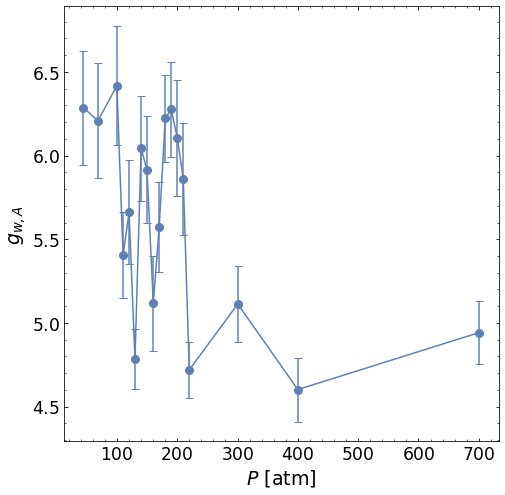

In [51]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gwA_mean, yerr=gwA_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$g_{w,A}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwA.png', dpi=150)
plt.show()

##### Metric B

In [52]:
gwB_mean = np.zeros(npress)
gwB_err  = np.zeros(npress)

for i in range(npress):
  gwB_mean[i] = np.mean(gwB_vec[i])
  gwB_err[i] = np.std(2*gwB_vec[i])/np.sqrt(len(gwB_vec[i]))

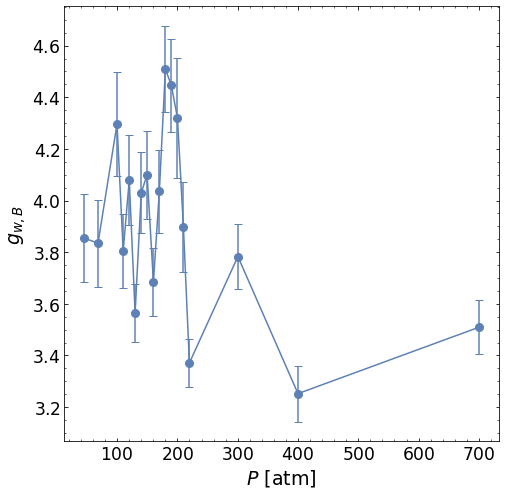

In [53]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gwB_mean, yerr=gwB_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$g_{w,B}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwB.png', dpi=150)
plt.show()

##### Metric C

In [54]:
gwC_mean = np.zeros(npress)
gwC_err  = np.zeros(npress)

for i in range(npress):
  gwC_mean[i] = np.mean(gwC_vec[i])
  gwC_err[i] = np.std(2*gwC_vec[i])/np.sqrt(len(gwC_vec[i]))

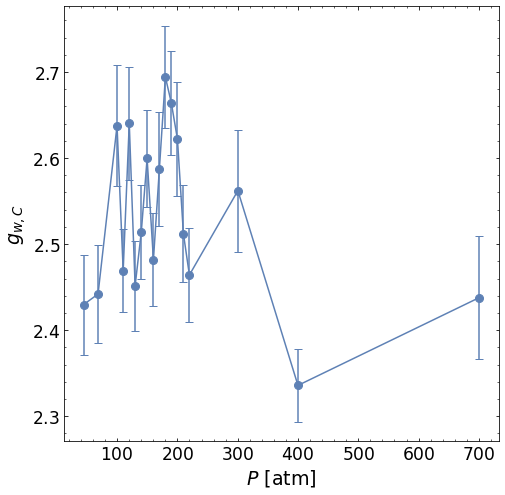

In [55]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gwC_mean, yerr=gwC_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$g_{w,C}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwC.png', dpi=150)
plt.show()

#### Comparison

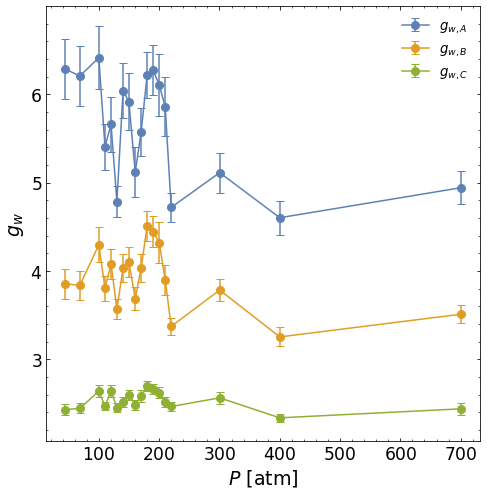

In [56]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gwA_mean, yerr=gwA_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,A}$")
plt.errorbar(pressure, gwB_mean, yerr=gwB_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,B}$")
plt.errorbar(pressure, gwC_mean, yerr=gwC_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,C}$")
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$g_w$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.legend(loc='upper right', fontsize=0.7*ft, frameon=False)
# plt.savefig('../plots/gw.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

#### Radii of gyration

In [62]:
gyrA_vec = []
gyrB_vec = []
gyrC_vec = []

In [63]:
for i in pressure_org:
  path2 = path + str(i) + '_atm/5-production_npt/gyr_'
  
  gyrA = pd.read_csv(path2 + 'A.dat', delim_whitespace=True, comment='#', header=None)
  gyrB = pd.read_csv(path2 + 'B.dat', delim_whitespace=True, comment='#', header=None)
  gyrC = pd.read_csv(path2 + 'C.dat', delim_whitespace=True, comment='#', header=None)
  
  gyrA_vec.append(gyrA.loc[:,1]/10)
  gyrB_vec.append(gyrB.loc[:,1]/10)
  gyrC_vec.append(gyrC.loc[:,1]/10)

##### Metric A

In [64]:
gyrA_mean = np.zeros(npress)
gyrA_err  = np.zeros(npress)

for i in range(npress):
  gyrA_mean[i] = np.mean(gyrA_vec[i])
  gyrA_err[i] = np.std(2*gyrA_vec[i])/np.sqrt(len(gyrA_vec[i]))

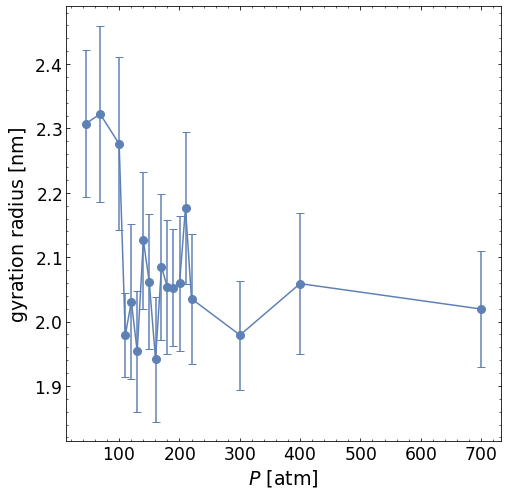

In [65]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gyrA_mean, yerr=gyrA_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$\mathrm{gyration \ radius \ [nm]}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwA.png', dpi=150)
plt.show()

##### Metric B

In [66]:
gyrB_mean = np.zeros(npress)
gyrB_err  = np.zeros(npress)

for i in range(npress):
  gyrB_mean[i] = np.mean(gyrB_vec[i])
  gyrB_err[i] = np.std(2*gyrB_vec[i])/np.sqrt(len(gyrB_vec[i]))

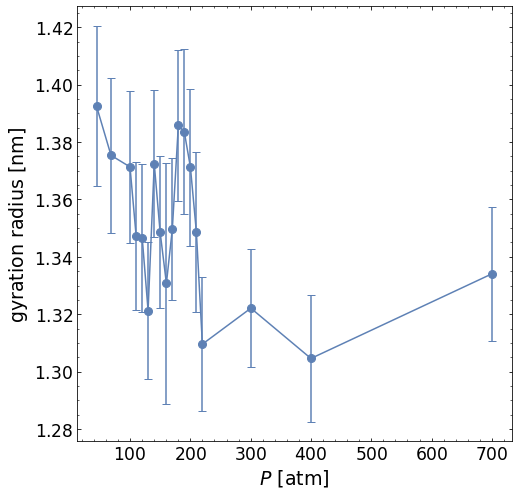

In [67]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gyrB_mean, yerr=gyrB_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$\mathrm{gyration \ radius \ [nm]}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwA.png', dpi=150)
plt.show()

##### Metric C

In [68]:
gyrC_mean = np.zeros(npress)
gyrC_err  = np.zeros(npress)

for i in range(npress):
  gyrC_mean[i] = np.mean(gyrC_vec[i])
  gyrC_err[i] = np.std(2*gyrC_vec[i])/np.sqrt(len(gyrC_vec[i]))

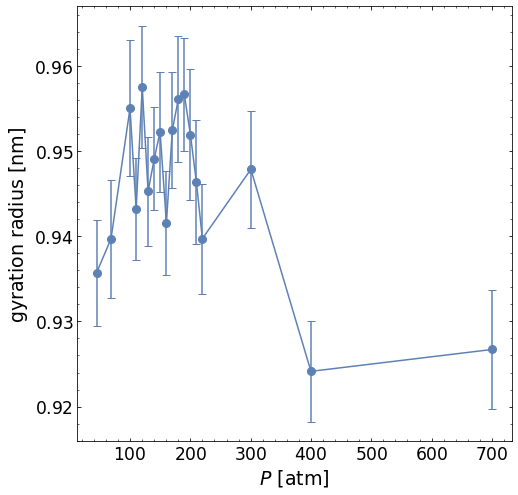

In [69]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gyrC_mean, yerr=gyrC_err, capsize=4, fmt='-o', markersize=8)
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$\mathrm{gyration \ radius \ [nm]}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
# plt.savefig('./plots/gwA.png', dpi=150)
plt.show()

#### Comparison

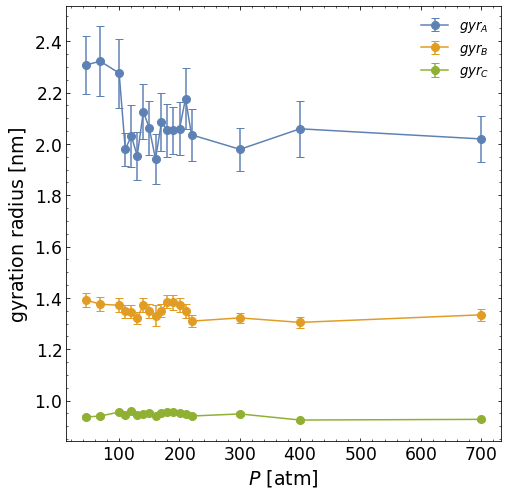

In [81]:
plt.figure(figsize=(8,8))
plt.gca().set_prop_cycle(color=colors)
plt.errorbar(pressure, gyrA_mean, yerr=gyrA_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{A}$")
plt.errorbar(pressure, gyrB_mean, yerr=gyrB_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{B}$")
plt.errorbar(pressure, gyrC_mean, yerr=gyrC_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{C}$")
plt.minorticks_on()
plt.tick_params(which='both', labelsize=0.9*ft, direction="in", right=True, top=True)
plt.ylabel(r'$\mathrm{gyration \ radius \ [nm]}$', fontsize=ft)
plt.xlabel(r'$P \ [\mathrm{atm}]$', fontsize=ft)
plt.gca().yaxis.offsetText.set_fontsize(0.85*ft)
plt.gca().xaxis.get_major_formatter()._usetex = True
plt.gca().yaxis.get_major_formatter()._usetex = True
plt.gca().set_box_aspect(1)
plt.legend(loc='upper right', fontsize=0.7*ft, frameon=False)
# plt.savefig('../plots/gw.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Potential energy and aggregation numbers

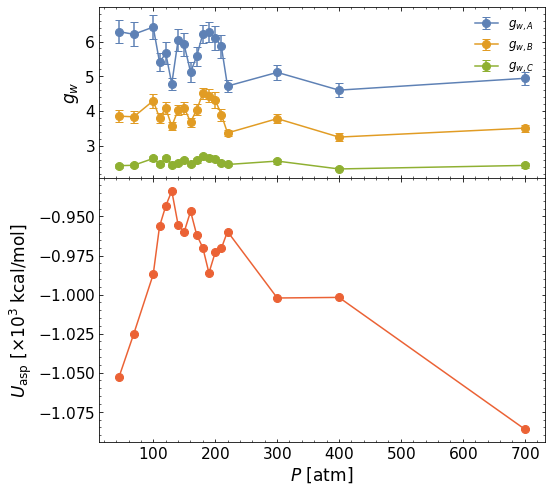

In [89]:
lft = 17
fig = plt.figure(figsize=(8,8))
(ax1, ax2) = fig.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[0.65,1]})

ax1.set_prop_cycle(color=colors)
ax1.errorbar(pressure, gwA_mean, yerr = gwA_err, capsize=4, fmt = '-o', markersize=8, label="$g_{w,A}$")
ax1.errorbar(pressure, gwB_mean, yerr = gwB_err, capsize=4, fmt = '-o', markersize=8, label="$g_{w,B}$")
ax1.errorbar(pressure, gwC_mean, yerr = gwC_err, capsize=4, fmt = '-o', markersize=8, label="$g_{w,C}$")
ax1.minorticks_on()
ax1.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
ax1.set_ylabel(r'$g_w$', fontsize=lft)
ax1.legend(loc='upper right', fontsize=0.7*lft, frameon=False)

ax2.set_prop_cycle(color=colors)
ax2.errorbar(pressure, pe_mean, yerr = pe_err, capsize=4, fmt = '-o', markersize=8, color=colors[3])
ax2.minorticks_on()
ax2.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
ax2.set_ylabel(r'$U_\mathrm{asp} \ [\times 10^3 \ \mathrm{kcal/mol}]$', fontsize=lft)
ax2.set_xlabel(r'$P \ [\mathrm{atm}]$', fontsize=lft)
ax2.xaxis.get_major_formatter()._usetex = True
ax2.yaxis.get_major_formatter()._usetex = True

fig.subplots_adjust(hspace=0)

# plt.savefig('../plots/pe+gw.png', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

## Aggregation numbers and radii of gyration

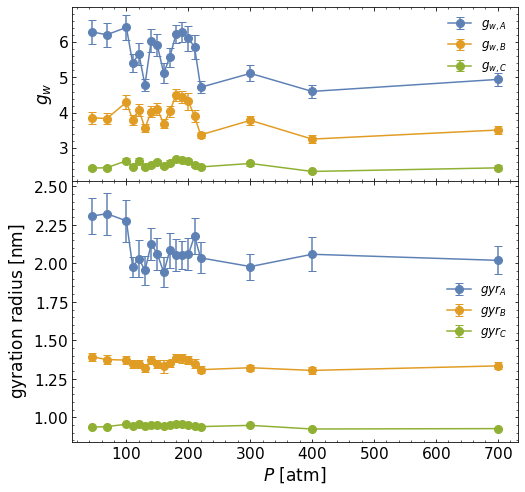

In [77]:
lft = 17
fig = plt.figure(figsize=(8,8))
(ax1, ax2) = fig.subplots(2, 1, sharex=True, gridspec_kw = {'height_ratios':[0.4,0.6]})

ax1.set_prop_cycle(color=colors)
ax1.errorbar(pressure, gwA_mean, yerr=gwA_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,A}$")
ax1.errorbar(pressure, gwB_mean, yerr=gwB_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,B}$")
ax1.errorbar(pressure, gwC_mean, yerr=gwC_err, capsize=4, fmt='-o', markersize=8, label="$g_{w,C}$")
ax1.minorticks_on()
ax1.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
ax1.set_ylabel(r'$g_w$', fontsize=lft)
ax1.legend(loc='upper right', fontsize=0.7*lft, frameon=False)

ax2.set_prop_cycle(color=colors)
ax2.errorbar(pressure, gyrA_mean, yerr=gyrA_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{A}$")
ax2.errorbar(pressure, gyrB_mean, yerr=gyrB_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{B}$")
ax2.errorbar(pressure, gyrC_mean, yerr=gyrC_err, capsize=4, fmt='-o', markersize=8, label="$gyr_{C}$")
ax2.minorticks_on()
ax2.tick_params(which='both', labelsize=0.9*lft, direction="in", right=True, top=True)
ax2.set_ylabel(r'$\mathrm{gyration \ radius \ [nm]}$', fontsize=lft)
ax2.set_xlabel(r'$P \ [\mathrm{atm}]$', fontsize=lft)
ax2.xaxis.get_major_formatter()._usetex = True
ax2.yaxis.get_major_formatter()._usetex = True
ax2.legend(loc='right', fontsize=0.7*lft, frameon=False)

fig.subplots_adjust(hspace=0)

# plt.savefig('../plots/gyr+gw.png', dpi=300, transparent=True, bbox_inches='tight')

plt.show()